In [1]:
import time
from copy import copy

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mixed_naive_bayes import MixedNB
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn import preprocessing, feature_selection, svm
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from skrebate import ReliefF

In [2]:
train_df = pd.read_csv('./input/train.csv')
test_df = pd.read_csv('./input/test.csv')
all_df = pd.concat([train_df, test_df])
X_train, y_train, X_test, y_test = [None, None, None, None]

# Análise Exploratória

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [18]:
train_df.isna().sum().to_frame()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


## Correlação

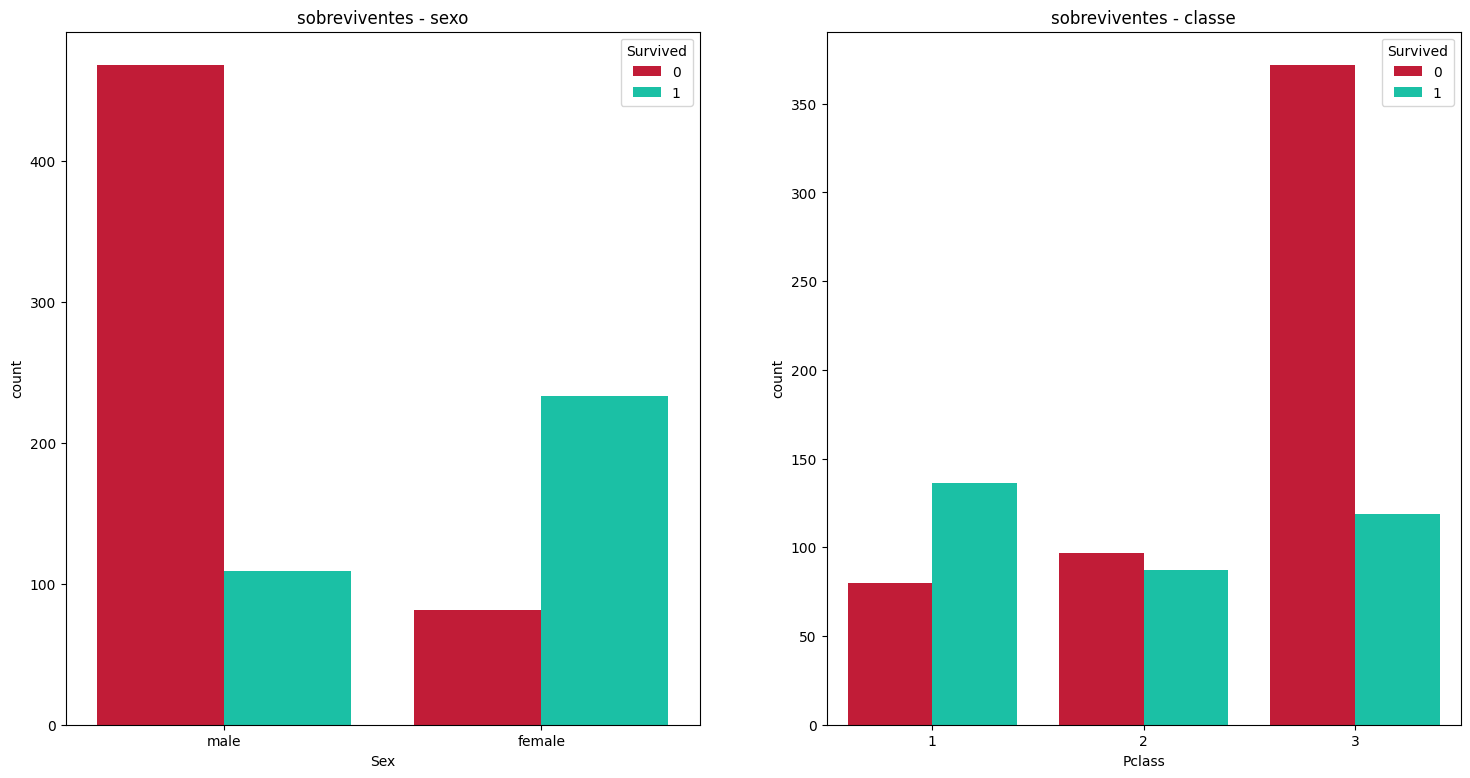

In [4]:
f, ax1 = plt.subplots(1, 2, figsize=(18,9))
sns.set_palette(["#DD0025", "#00DBB7"])
sns.countplot(train_df, x="Sex", hue="Survived", ax=ax1[0])
sns.countplot(train_df, x="Pclass", hue="Survived", ax=ax1[1])
ax1[0].set_title('sobreviventes - sexo')
ax1[1].set_title('sobreviventes - classe')
plt.show()

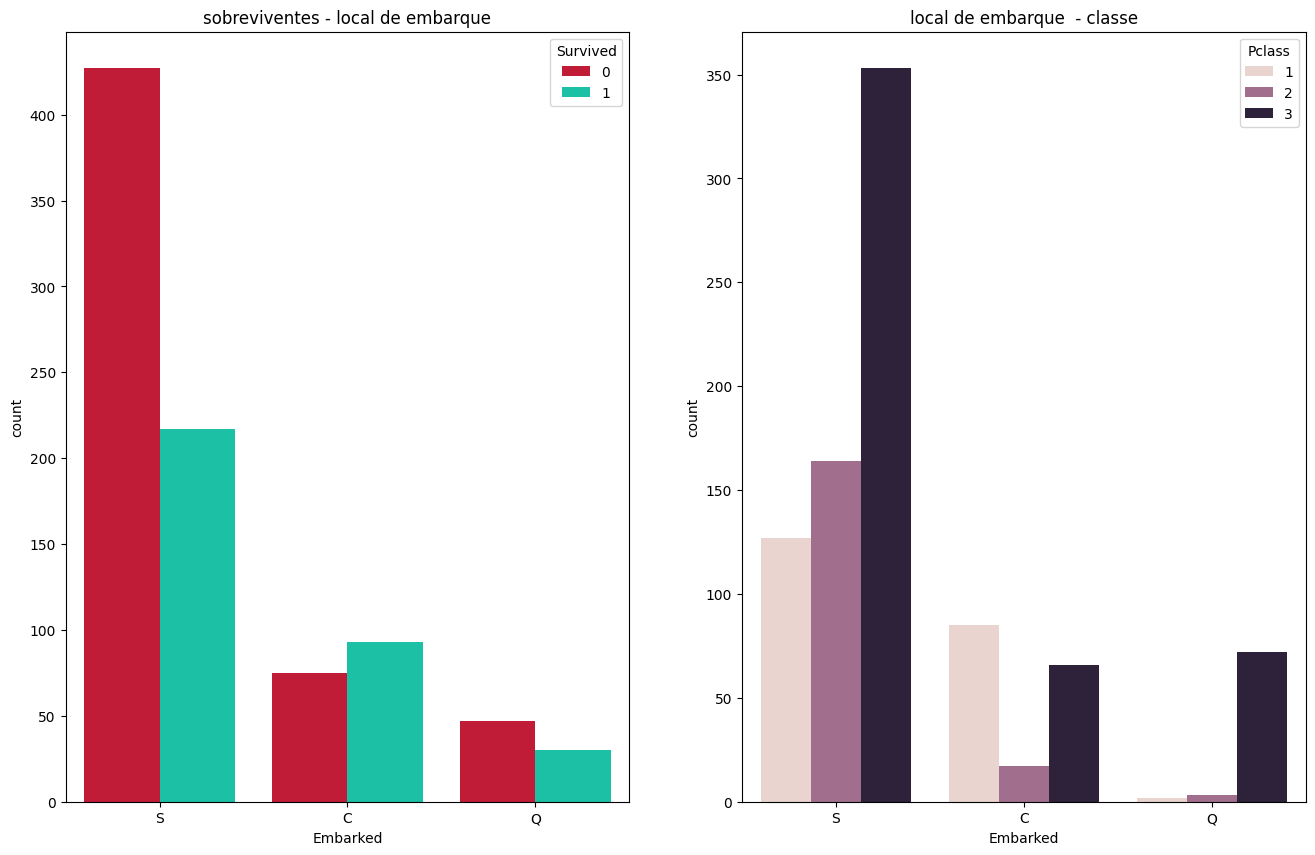

In [5]:
f, ax1 = plt.subplots(1, 2, figsize=(16,10))
sns.set_palette(["#DD0025", "#00DBB7"])
sns.countplot(train_df, x="Embarked", hue="Survived", ax=ax1[0])
sns.countplot(train_df, x="Embarked", hue="Pclass", ax=ax1[1])
ax1[0].set_title('sobreviventes - local de embarque')
ax1[1].set_title('local de embarque  - classe')
plt.show()
plt.show()

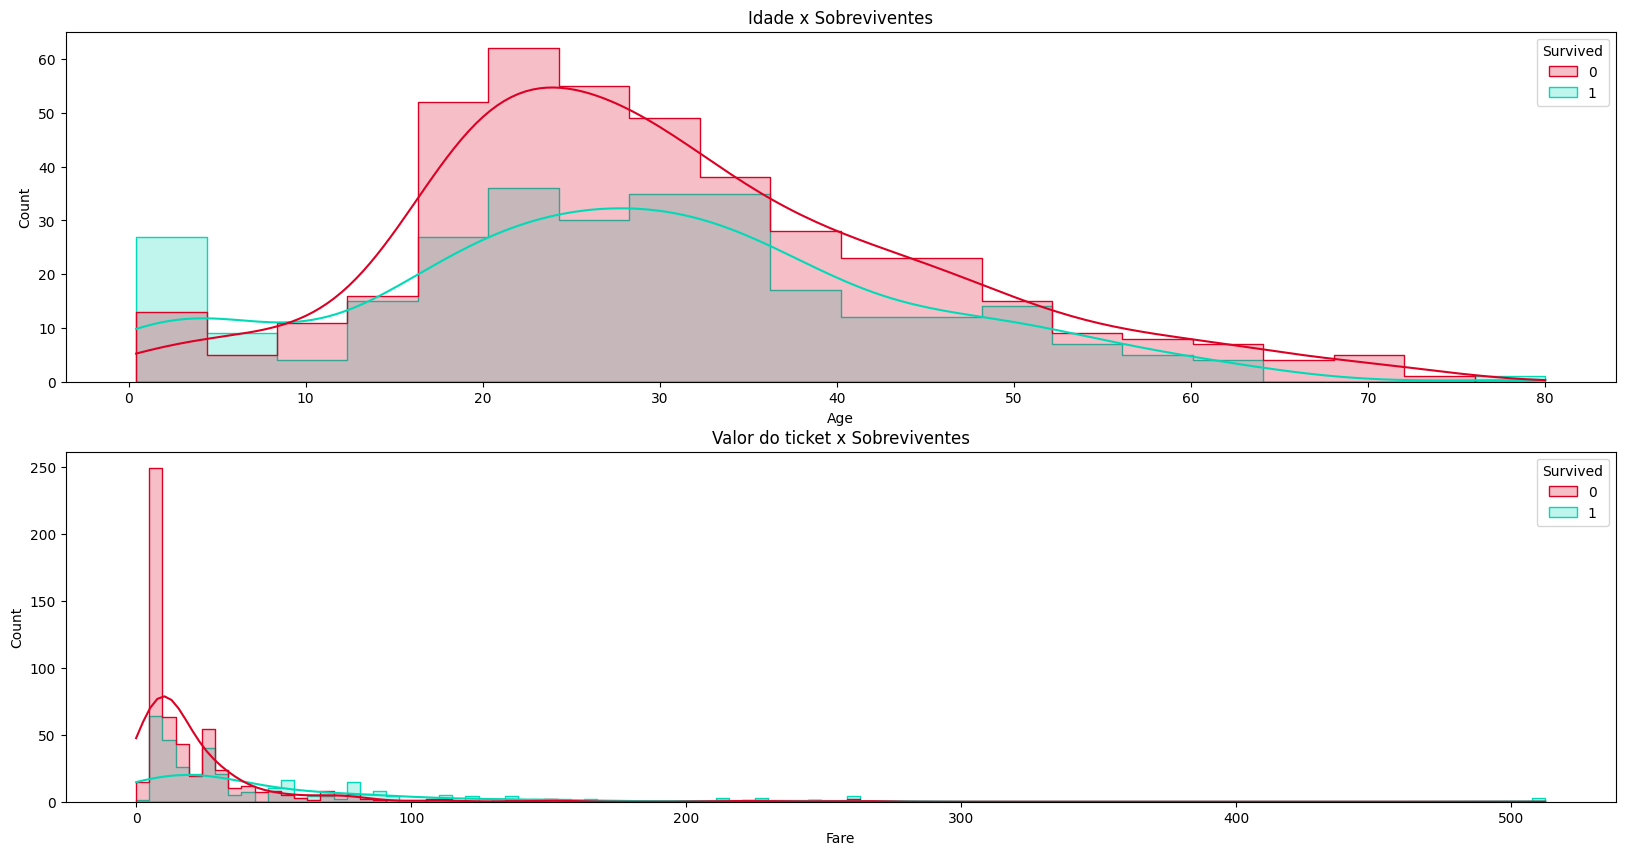

In [21]:
fig, ax = plt.subplots(nrows=2, figsize=(20, 10))
sns.histplot(data=train_df, x="Age", hue="Survived", element="step", kde=True, ax=ax[0])
sns.histplot(data=train_df, x="Fare", hue="Survived", element="step", kde=True, ax=ax[1])
ax[0].set_title('Idade x Sobreviventes')
ax[1].set_title('Valor do ticket x Sobreviventes')
plt.show()

# Pré-processamento

### Análise característica: Cabin

In [22]:
print(f'Quantidade de missing values na class Cabin {all_df['Cabin'].isna().sum()}')
print(f'Porcentagem de valores vazios na classe Cabin do total de passageiros: {(all_df['Cabin'].isna().sum()/len(all_df['Cabin'])) * 100:.2f}')

Quantidade de missing values na class Cabin 1014
Porcentagem de valores vazios na classe Cabin do total de passageiros: 77.46


Por que remover a classe `Cabin`:
- Muitas instâncias com _missing values_
- Qualquer alternativa de **imputação de valores** iria enviesar muito os valores gerados
- O dado em sí não tem muito "valor"

In [6]:
def pre_process(df):
    df = df.drop(columns=['PassengerId', 'Cabin', 'Name', 'Ticket'])
    df = df.drop_duplicates()

    # creating a new feature "FamilySize"
    df['FamilySize'] = df['SibSp'] + df['Parch']
    df = df.drop(columns=['SibSp', 'Parch'])
        
    # normalizing features
    num_features = ['Age', 'Fare']
    ord_features = ['Pclass', 'Sex']
    cat_features = ['Embarked']
    passthrough_columns = ['Survived', 'FamilySize']

        
    num_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', preprocessing.MinMaxScaler())
    ])
    ord_transformer = Pipeline(steps=[
        ('ordinal_encoder', preprocessing.OrdinalEncoder())
    ])
    cat_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('one_hot_encoder', preprocessing.OneHotEncoder(sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            (
                'num',
                num_transformer,
                num_features
            ),
            (
                'ord',
                ord_transformer,
                ord_features
            ),
            (
                'cat',
                cat_transformer,
                cat_features
            ),
        ], remainder='passthrough'
    )

    df_processed = preprocessor.fit_transform(df)

    # Get the passthrough columns (the ones not transformed)
    all_columns = (
        num_features +
        ord_features +
        list(preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features)) +
        passthrough_columns
    ) 
    df_processed = pd.DataFrame(df_processed, columns=all_columns)

    # remove fare outliers
    fare_threshold = df_processed["Fare"].quantile(0.999)
    df_processed = df_processed[df_processed["Fare"] < fare_threshold]

    # removing na 
    df_processed = df_processed.dropna()

    # transforming everything to numeric
    df_processed = df_processed.apply(pd.to_numeric)

    X = df_processed.drop(columns='Survived')
    y = df_processed['Survived'].astype(int)

    return X, y

In [7]:
X_train, y_train = pre_process(train_df)

In [8]:
X_train_with_label = copy(X_train)
X_train_with_label['Survived'] = y_train

### Análise de característica: Age

Quantidade de valores vazios na característica age: 263
Média de idade: 29.88


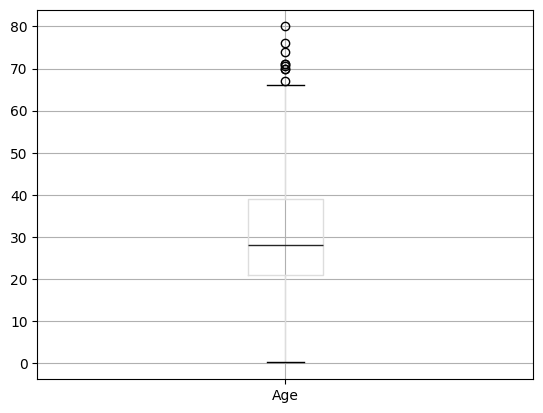

In [9]:
print(f'Quantidade de valores vazios na característica age: {all_df['Age'].isna().sum()}')
print(f'Média de idade: {all_df['Age'].mean():.2f}')
all_df.boxplot(['Age'])
plt.show()

In [ ]:
# Plotar histograma antes de preencher os valores nulos
plt.figure(figsize=(12, 6))
sns.histplot(train_df['Age'], bins=30, kde=False, color='blue', label='Antes de preencher')
plt.axvline(train_df['Age'].mean(), color='red', linestyle='dashed', linewidth=2, label='Média')
plt.title('Distribuição das Idades - Antes de Preencher')
plt.legend()
plt.show()

In [ ]:
# Plotar histograma depois de preencher os valores nulos
plt.figure(figsize=(12, 6))
sns.histplot(X_train['Age'], bins=30, kde=False, color='green', label='Depois de preencher')
plt.axvline(X_train['Age'].mean(), color='red', linestyle='dashed', linewidth=2, label='Média')
plt.title('Distribuição das Idades - Depois de Preencher')
plt.legend()
plt.show()

### Análise de outliers

In [ ]:
x = X_train['Fare']
y = X_train['Age']

# plot
fig, ax = plt.subplots(figsize=(10, 5), layout='constrained')

ax.scatter(x, y)
ax.set_xlabel('Valor pago no ticket')
ax.set_ylabel('Idade')

plt.show()

## Criando nova característica FamilySize

Característica criada a partir de “SibSp” e “Parch”

In [ ]:
family_survival_rate = X_train_with_label.groupby('FamilySize')['Survived'].mean().reset_index()

In [ ]:
# Plotar o gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x='FamilySize', y='Survived', data=family_survival_rate, palette='viridis')

# Títulos e rótulos
plt.title('Taxa de Sobrevivência vs. Tamanho da Família', fontsize=16)
plt.xlabel('Tamanho da Família', fontsize=14)
plt.ylabel('Taxa de Sobrevivência', fontsize=14)
plt.show()

## Correlações entre as caracteristicas

In [ ]:
correlation_matrix = X_train_with_label.corr() # Pearson's coefficient

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Matriz de correlação')
plt.show()

## Balanceamento

Decidimos por não realizar nenhum método de balanceamento pois há poucas instâncias no dataset e poderíamos enviezar os dados caso aplicassemos algum método.

In [ ]:
labels = ['Sobreviventes', 'Mortes']
colors = ["#DD0025", "#00DBB7"]
y_positive = y_train[y_train == 1]
y_negative = y_train[y_train == 0]
fig = plt.figure()
ax = fig.subplots()

ax.bar(labels, [y_positive.count(), y_negative.count()], color=colors)
ax.set_ylabel('Quantidade de passageiros')
ax.set_title('Balanceamento de classes no dataset')
plt.show()

# Processamento

A amostra de treino será separada K vezes para que consigamos treinar os classificadores e ter uma estimativa mais correta

## Naive Bayes

In [7]:
K_FOLD = 10
results_df = pd.DataFrame(
    columns=[
        'f1_mean',
        'f1_std',
        'accuracy_mean',
        'accuracy_std',
        'recall_mean',
        'recall_std',
        'precision_mean',
        'precision_std'
    ], 
    index=['all_feat', 'pca', 'relieff', 'sfs']
)

all_feat_f1_score = []
all_feat_precision_score = []
all_feat_recall_score = []
all_feat_accuracy_score = []

relieff_f1_score = []
relieff_precision_score = []
relieff_recall_score = []
relieff_accuracy_score = []

sfs_f1_score = []
sfs_precision_score = []
sfs_recall_score = []
sfs_accuracy_score = []

pca_f1_score = []
pca_precision_score = []
pca_recall_score = []
pca_accuracy_score = []

nb_execution_time = []

skf = StratifiedKFold(n_splits=K_FOLD, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X_train, y_train):
    start_time = time.time()
    X_train_fold = X_train.iloc[train_index]
    y_train_fold = y_train.iloc[train_index]
    
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train.iloc[test_index]

    # all features classifier
    nb_all_feat_clf = MixedNB(categorical_features=[2, 3, 4, 5, 6])
    nb_all_feat_clf.fit(X_train_fold, y_train_fold.values)
    y_pred = nb_all_feat_clf.predict(X_test_fold.values)
    
    all_feat_f1_score.append(metrics.f1_score(y_test_fold, y_pred))
    all_feat_precision_score.append(metrics.precision_score(y_test_fold, y_pred))
    all_feat_recall_score.append(metrics.recall_score(y_test_fold, y_pred))
    all_feat_accuracy_score.append(metrics.accuracy_score(y_test_fold, y_pred))

     # relieff
    relieff_clf = make_pipeline(
        ReliefF(n_features_to_select=4),
        MixedNB(categorical_features=[0, 1]),
    )

    relieff_clf.fit(X_train_fold.values, y_train_fold.values)
    y_pred = relieff_clf.predict(X_test_fold.values)

    relieff_f1_score.append(metrics.f1_score(y_test_fold, y_pred))
    relieff_precision_score.append(metrics.precision_score(y_test_fold, y_pred))
    relieff_recall_score.append(metrics.recall_score(y_test_fold, y_pred))
    relieff_accuracy_score.append(metrics.accuracy_score(y_test_fold, y_pred))

    # SFS feat selection
    nb_clf = MixedNB()
    nb_sfs = feature_selection.SequentialFeatureSelector(RandomForestClassifier(), direction='backward', n_features_to_select=4)
    nb_sfs.fit(X_train_fold, y_train_fold.values)
    print(nb_sfs.get_support())
    
    nb_clf.fit(X_train_fold, y_train_fold.values)
    y_pred = nb_clf.predict(X_test_fold.values)
                                                      
    sfs_f1_score.append(metrics.f1_score(y_test_fold, y_pred))
    sfs_precision_score.append(metrics.precision_score(y_test_fold, y_pred))
    sfs_recall_score.append(metrics.recall_score(y_test_fold, y_pred))
    sfs_accuracy_score.append(metrics.accuracy_score(y_test_fold, y_pred))
    
    # PCA
    pca = PCA(n_components=4)
    principal_components = pca.fit_transform(X_train_fold)
    pca_X_train = pd.DataFrame(
        data=principal_components,
        columns=['PC1', 'PC2', 'PC3', 'PC4']
    )
    principal_components_test = pca.fit_transform(X_test_fold)
    pca_X_test = pd.DataFrame(
        data=principal_components_test,
        columns=['PC1', 'PC2', 'PC3', 'PC4']
    )

    clf = GaussianNB()
    nb_pca_grid_search_clf = GridSearchCV(
        clf,
        {
            'var_smoothing': [1e-9, 1e-6, 0.00001, 0.0001],
        },
        cv=2,
        n_jobs=-1,
        scoring='f1_weighted'
    )
    nb_pca_grid_search_clf.fit(X_train_fold, y_train_fold.values)
    y_pred = nb_pca_grid_search_clf.predict(X_test_fold)

    pca_f1_score.append(metrics.f1_score(y_test_fold, y_pred))
    pca_precision_score.append(metrics.precision_score(y_test_fold, y_pred))
    pca_recall_score.append(metrics.recall_score(y_test_fold, y_pred))
    pca_accuracy_score.append(metrics.accuracy_score(y_test_fold, y_pred))
    end_time = time.time()
    print(end_time - start_time)
    nb_execution_time.append(end_time - start_time)


# pca results
results_df.at['pca', 'f1_mean'] = np.mean(pca_f1_score)
results_df.at['pca', 'f1_std'] = np.std(pca_f1_score)
results_df.at['pca', 'precision_mean'] = np.mean(pca_precision_score)
results_df.at['pca', 'precision_std'] = np.std(pca_precision_score)
results_df.at['pca', 'recall_mean'] = np.mean(pca_recall_score)
results_df.at['pca', 'recall_std'] = np.std(pca_recall_score)
results_df.at['pca', 'accuracy_mean'] = np.mean(pca_accuracy_score)
results_df.at['pca', 'accuracy_std'] = np.std(pca_accuracy_score)
    
# sfs results
results_df.at['sfs', 'f1_mean'] = np.mean(sfs_f1_score)
results_df.at['sfs', 'f1_std'] = np.std(sfs_f1_score)
results_df.at['sfs', 'precision_mean'] = np.mean(sfs_precision_score)
results_df.at['sfs', 'precision_std'] = np.std(sfs_precision_score)
results_df.at['sfs', 'recall_mean'] = np.mean(sfs_recall_score)
results_df.at['sfs', 'recall_std'] = np.std(sfs_recall_score)
results_df.at['sfs', 'accuracy_mean'] = np.mean(sfs_accuracy_score)
results_df.at['sfs', 'accuracy_std'] = np.std(sfs_accuracy_score)

# all feat result
results_df.at['all_feat', 'f1_mean'] = np.mean(all_feat_f1_score)
results_df.at['all_feat', 'f1_std'] = np.std(all_feat_f1_score)
results_df.at['all_feat', 'precision_mean'] = np.mean(all_feat_precision_score)
results_df.at['all_feat', 'precision_std'] = np.std(all_feat_precision_score)    
results_df.at['all_feat', 'recall_mean'] = np.mean(all_feat_recall_score)
results_df.at['all_feat', 'recall_std'] = np.std(all_feat_recall_score)   
results_df.at['all_feat', 'accuracy_mean'] = np.mean(all_feat_accuracy_score)
results_df.at['all_feat', 'accuracy_std'] = np.std(all_feat_accuracy_score)

# # relieff results
results_df.at['relieff', 'f1_mean'] = np.mean(relieff_f1_score)
results_df.at['relieff', 'f1_std'] = np.std(relieff_f1_score)
results_df.at['relieff', 'precision_mean'] = np.mean(relieff_precision_score)
results_df.at['relieff', 'precision_std'] = np.std(relieff_precision_score)
results_df.at['relieff', 'recall_mean'] = np.mean(relieff_recall_score)
results_df.at['relieff', 'recall_std'] = np.std(relieff_recall_score)
results_df.at['relieff', 'accuracy_mean'] = np.mean(relieff_accuracy_score)
results_df.at['relieff', 'accuracy_std'] = np.std(relieff_accuracy_score)

[False False  True  True  True  True False False]
10.150819063186646
[ True  True  True  True False False False False]
8.919964075088501
[ True False  True  True False False  True False]
8.550938129425049
[ True  True  True  True False False False False]
8.683470010757446
[False False  True  True False  True  True False]
8.215148210525513
[False  True  True  True False  True False False]
8.704396724700928
[ True  True  True  True False False False False]
9.246975898742676
[False  True  True  True False False False  True]
8.816200017929077
[False  True  True  True False False False  True]
8.291177988052368
[False  True  True  True False False False  True]
8.776898860931396


In [16]:
print(f'Parametros selecionados - Relieff: {nb_relieff_grid_search_clf.best_params_}')
print(f'SFS: {nb_sfs_grid_search_clf.best_params_}')
nb_sfs_grid_search_clf.best_estimator_.steps[0][1].get_feature_names_out()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/lievi/Documents/estudos/mestrado/rec_padroes/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
    ~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/jg/7z54w3515q3fm34byqrlmcl00000gn/T/ipykernel_39860/2230703762.py", line 1, in <module>
    print(f'Parametros selecionados - Relieff: {nb_relieff_grid_search_clf.best_params_}')
                                                ^^^^^^^^^^^^^^^^^^^^^^^^^^
NameError: name 'nb_relieff_grid_search_clf' is not defined. Did you mean: 'nb_pca_grid_search_clf'?

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/lievi/Documents/estudos/mestrado/rec_padroes/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 2168, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
        etype,

## Random Forest

In [8]:
K_FOLD = 10
HYPER_PARAMS = {'max_features': ['sqrt', 'log2', None], 'n_estimators': [500, 600, 1000]}
rf_results_df = pd.DataFrame(
    columns=[
        'f1_mean',
        'f1_std',
        'accuracy_mean',
        'accuracy_std',
        'recall_mean',
        'recall_std',
        'precision_mean',
        'precision_std'
    ], 
    index=['all_feat', 'pca', 'relieff', 'sfs']
)

all_feat_f1_score = []
all_feat_precision_score = []
all_feat_recall_score = []
all_feat_accuracy_score = []

relieff_f1_score = []
relieff_precision_score = []
relieff_recall_score = []
relieff_accuracy_score = []

sfs_f1_score = []
sfs_precision_score = []
sfs_recall_score = []
sfs_accuracy_score = []

pca_f1_score = []
pca_precision_score = []
pca_recall_score = []
pca_accuracy_score = []

rf_execution_time = []
skf = StratifiedKFold(n_splits=K_FOLD, shuffle=True, random_state=42)

for train_index, test_index in skf.split(X_train, y_train):
    start_time = time.time()
    X_train_fold = X_train.iloc[train_index]
    y_train_fold = y_train.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train.iloc[test_index]

    # all features classifier
    
    all_feat_clf = RandomForestClassifier()
    # all_feat_clf.fit(X_train_fold, y_train_fold.values)
    # y_pred = all_feat_clf.predict(X_test_fold.values)
    
    rf_all_feat_grid_search_clf = GridSearchCV(
        all_feat_clf,
        HYPER_PARAMS,
        cv=2,
        n_jobs=-1,
        scoring='f1_weighted'
    )
    rf_all_feat_grid_search_clf.fit(X_train_fold.values, y_train_fold.values)
    y_pred = rf_all_feat_grid_search_clf.predict(X_test_fold.values)

    
    all_feat_f1_score.append(metrics.f1_score(y_test_fold, y_pred))
    all_feat_precision_score.append(metrics.precision_score(y_test_fold, y_pred))
    all_feat_recall_score.append(metrics.recall_score(y_test_fold, y_pred))
    all_feat_accuracy_score.append(metrics.accuracy_score(y_test_fold, y_pred))

    # relieff
    
    relieff_clf = make_pipeline(
        ReliefF(),
        RandomForestClassifier(),
    )
    # relieff_clf.fit(X_train_fold.values, y_train_fold.values)
    # y_pred = relieff_clf.predict(X_test_fold.values)

    rf_relieff_grid_search_clf = GridSearchCV(
        relieff_clf,
        {
            'relieff__n_features_to_select': [3, 4, 5, 6, 7, 8],
            'randomforestclassifier__max_features': ['sqrt', 'log2', None], 
            'randomforestclassifier__n_estimators': [500, 600, 1000]
        },
        cv=2,
        n_jobs=-1,
        scoring='f1_weighted'
    )
    rf_relieff_grid_search_clf.fit(X_train_fold.values, y_train_fold.values)
    y_pred = rf_relieff_grid_search_clf.predict(X_test_fold.values)

    relieff_f1_score.append(metrics.f1_score(y_test_fold, y_pred))
    relieff_precision_score.append(metrics.precision_score(y_test_fold, y_pred))
    relieff_recall_score.append(metrics.recall_score(y_test_fold, y_pred))
    relieff_accuracy_score.append(metrics.accuracy_score(y_test_fold, y_pred))


    # SFS feat selection

    rf_clf = RandomForestClassifier()
    sfs = feature_selection.SequentialFeatureSelector(rf_clf, direction='backward')
    sfs_clf = make_pipeline(
        sfs,
        rf_clf
    )

    # clf.fit(sfs_X_train, y_train_fold)
    # y_pred = clf.predict(sfs_X_test)

    rf_sfs_grid_search_clf = GridSearchCV(
        sfs_clf,
        {
            'randomforestclassifier__max_features': ['sqrt', 'log2', None], 
            'randomforestclassifier__n_estimators': [500, 600, 1000],
            'sequentialfeatureselector__n_features_to_select': [3, 4, 5, 6, 7]        
        },
        cv=2,
        n_jobs=-1,
        scoring='f1_weighted'
    )
    rf_sfs_grid_search_clf.fit(X_train_fold, y_train_fold.values)
    y_pred = rf_sfs_grid_search_clf.predict(X_test_fold)

    sfs_f1_score.append(metrics.f1_score(y_test_fold, y_pred))
    sfs_precision_score.append(metrics.precision_score(y_test_fold, y_pred))
    sfs_recall_score.append(metrics.recall_score(y_test_fold, y_pred))
    sfs_accuracy_score.append(metrics.accuracy_score(y_test_fold, y_pred))

    # PCA
    
    pca = PCA(n_components=4)
    principal_components = pca.fit_transform(X_train_fold)
    pca_X_train = pd.DataFrame(
        data=principal_components,
        columns=['PC1', 'PC2', 'PC3', 'PC4']
    )
    principal_components_test = pca.fit_transform(X_test_fold)
    pca_X_test = pd.DataFrame(
        data=principal_components_test,
        columns=['PC1', 'PC2', 'PC3', 'PC4']
    )

    pca_clf = RandomForestClassifier()
    # clf.fit(pca_X_train, y_train_fold)
    # y_pred = clf.predict(pca_X_test)
    
    rf_pca_grid_search_clf = GridSearchCV(
        pca_clf,
        HYPER_PARAMS,
        cv=2,
        n_jobs=-1,
        scoring='f1_weighted'
    )
    rf_pca_grid_search_clf.fit(pca_X_train.values, y_train_fold.values)
    y_pred = rf_pca_grid_search_clf.predict(pca_X_test.values)

    pca_f1_score.append(metrics.f1_score(y_test_fold, y_pred))
    pca_precision_score.append(metrics.precision_score(y_test_fold, y_pred))
    pca_recall_score.append(metrics.recall_score(y_test_fold, y_pred))
    pca_accuracy_score.append(metrics.accuracy_score(y_test_fold, y_pred))
    end_time = time.time()
    rf_execution_time.append(end_time - start_time)
    print(end_time - start_time)


# pca results
rf_results_df.at['pca', 'f1_mean'] = np.mean(pca_f1_score)
rf_results_df.at['pca', 'f1_std'] = np.std(pca_f1_score)
rf_results_df.at['pca', 'precision_mean'] = np.mean(pca_precision_score)
rf_results_df.at['pca', 'precision_std'] = np.std(pca_precision_score)
rf_results_df.at['pca', 'recall_mean'] = np.mean(pca_recall_score)
rf_results_df.at['pca', 'recall_std'] = np.std(pca_recall_score)
rf_results_df.at['pca', 'accuracy_mean'] = np.mean(pca_accuracy_score)
rf_results_df.at['pca', 'accuracy_std'] = np.std(pca_accuracy_score)
    
# sfs results
rf_results_df.at['sfs', 'f1_mean'] = np.mean(sfs_f1_score)
rf_results_df.at['sfs', 'f1_std'] = np.std(sfs_f1_score)
rf_results_df.at['sfs', 'precision_mean'] = np.mean(sfs_precision_score)
rf_results_df.at['sfs', 'precision_std'] = np.std(sfs_precision_score)
rf_results_df.at['sfs', 'recall_mean'] = np.mean(sfs_recall_score)
rf_results_df.at['sfs', 'recall_std'] = np.std(sfs_recall_score)
rf_results_df.at['sfs', 'accuracy_mean'] = np.mean(sfs_accuracy_score)
rf_results_df.at['sfs', 'accuracy_std'] = np.std(sfs_accuracy_score)

# all feat result
rf_results_df.at['all_feat', 'f1_mean'] = np.mean(all_feat_f1_score)
rf_results_df.at['all_feat', 'f1_std'] = np.std(all_feat_f1_score)
rf_results_df.at['all_feat', 'precision_mean'] = np.mean(all_feat_precision_score)
rf_results_df.at['all_feat', 'precision_std'] = np.std(all_feat_precision_score)    
rf_results_df.at['all_feat', 'recall_mean'] = np.mean(all_feat_recall_score)
rf_results_df.at['all_feat', 'recall_std'] = np.std(all_feat_recall_score)   
rf_results_df.at['all_feat', 'accuracy_mean'] = np.mean(all_feat_accuracy_score)
rf_results_df.at['all_feat', 'accuracy_std'] = np.std(all_feat_accuracy_score)

# # relieff results
rf_results_df.at['relieff', 'f1_mean'] = np.mean(relieff_f1_score)
rf_results_df.at['relieff', 'f1_std'] = np.std(relieff_f1_score)
rf_results_df.at['relieff', 'precision_mean'] = np.mean(relieff_precision_score)
rf_results_df.at['relieff', 'precision_std'] = np.std(relieff_precision_score)
rf_results_df.at['relieff', 'recall_mean'] = np.mean(relieff_recall_score)
rf_results_df.at['relieff', 'recall_std'] = np.std(relieff_recall_score)
rf_results_df.at['relieff', 'accuracy_mean'] = np.mean(relieff_accuracy_score)
rf_results_df.at['relieff', 'accuracy_std'] = np.std(relieff_accuracy_score)

113.50871276855469
113.53627109527588
113.55404996871948
115.47367095947266
111.08052706718445
115.36981725692749
115.48981499671936
120.58962988853455
116.68597483634949
128.59433221817017


In [172]:
print(f'All Params: {rf_all_feat_grid_search_clf.best_params_}')
print(f'Relieff: {rf_relieff_grid_search_clf.best_params_}')
print(f'SFS: {rf_sfs_grid_search_clf.best_params_}')
rf_sfs_grid_search_clf.best_estimator_.steps[0][1].get_feature_names_out()

All Params: {'max_features': 'log2', 'n_estimators': 600}
Relieff: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 500, 'relieff__n_features_to_select': 3}
SFS: {'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 500, 'sequentialfeatureselector__n_features_to_select': 3}


array(['Fare', 'Pclass', 'Sex'], dtype=object)

## SVM

In [13]:
K_FOLD = 10
HYPER_PARAMS = {
    'C': [1e-2, 1e-1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

svm_results_df = pd.DataFrame(
    columns=[
        'f1_mean',
        'f1_std',
        'accuracy_mean',
        'accuracy_std',
        'recall_mean',
        'recall_std',
        'precision_mean',
        'precision_std'
    ], 
    index=['all_feat', 'pca', 'relieff', 'sfs']
)


all_feat_f1_score = []
all_feat_precision_score = []
all_feat_recall_score = []
all_feat_accuracy_score = []

relieff_f1_score = []
relieff_precision_score = []
relieff_recall_score = []
relieff_accuracy_score = []

sfs_f1_score = []
sfs_precision_score = []
sfs_recall_score = []
sfs_accuracy_score = []

pca_f1_score = []
pca_precision_score = []
pca_recall_score = []
pca_accuracy_score = []

skf = StratifiedKFold(n_splits=K_FOLD, shuffle=True, random_state=42)
svc_execution_time = []

for train_index, test_index in skf.split(X_train, y_train):
    start_time = time.time()
    X_train_fold = X_train.iloc[train_index]
    y_train_fold = y_train.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train.iloc[test_index]

    # all features classifier
    
    all_feat_clf = svm.SVC()
    #all_feat_clf.fit(X_train_fold.values, y_train_fold.values)
    #y_pred = all_feat_clf.predict(X_test_fold.values)
    
    svm_all_feat_grid_search_clf = GridSearchCV(
        all_feat_clf,
        HYPER_PARAMS,
        cv=2,
        n_jobs=-1,
        scoring='f1_weighted'
    )
    svm_all_feat_grid_search_clf.fit(X_train_fold.values, y_train_fold.values)
    y_pred = svm_all_feat_grid_search_clf.predict(X_test_fold.values)

    
    all_feat_f1_score.append(metrics.f1_score(y_test_fold, y_pred))
    all_feat_precision_score.append(metrics.precision_score(y_test_fold, y_pred))
    all_feat_recall_score.append(metrics.recall_score(y_test_fold, y_pred))
    all_feat_accuracy_score.append(metrics.accuracy_score(y_test_fold, y_pred))

    # relieff
    
    relieff_clf = make_pipeline(
        ReliefF(),
        svm.SVC(),
    )
    #relieff_clf.fit(X_train_fold.values, y_train_fold.values)
    #y_pred = relieff_clf.predict(X_test_fold.values)

    svm_relieff_grid_search_clf = GridSearchCV(
        relieff_clf,
        {
            'relieff__n_features_to_select': [4, 5, 6, 7, 8],
            'svc__C': [1e-2, 1e-1, 1, 10], 
            'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid']
        },
        cv=2,
        n_jobs=-1,
        scoring='f1_weighted'
    )
    svm_relieff_grid_search_clf.fit(X_train_fold.values, y_train_fold.values)
    y_pred = svm_relieff_grid_search_clf.predict(X_test_fold.values)

    relieff_f1_score.append(metrics.f1_score(y_test_fold, y_pred))
    relieff_precision_score.append(metrics.precision_score(y_test_fold, y_pred))
    relieff_recall_score.append(metrics.recall_score(y_test_fold, y_pred))
    relieff_accuracy_score.append(metrics.accuracy_score(y_test_fold, y_pred))


    # SFS feat selection
    svc = svm.SVC()
    sfs = feature_selection.SequentialFeatureSelector(svc, direction='backward')
    sfs_clf = make_pipeline(
        sfs,
        svc,
    )

    #clf.fit(sfs_X_train, y_train_fold)
    #y_pred = clf.predict(sfs_X_test)

    svc_sfs_grid_search_clf = GridSearchCV(
        sfs_clf,
        {
            'svc__C': [1e-2, 1e-1, 1, 10],
            'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
            'sequentialfeatureselector__n_features_to_select': [3, 4, 5, 6, 7]
        },
        cv=2,
        n_jobs=-1,
        scoring='f1_weighted'
    )
    svc_sfs_grid_search_clf.fit(X_train_fold, y_train_fold.values)
    y_pred = svc_sfs_grid_search_clf.predict(X_test_fold)

    sfs_f1_score.append(metrics.f1_score(y_test_fold, y_pred))
    sfs_precision_score.append(metrics.precision_score(y_test_fold, y_pred))
    sfs_recall_score.append(metrics.recall_score(y_test_fold, y_pred))
    sfs_accuracy_score.append(metrics.accuracy_score(y_test_fold, y_pred))

    # PCA
    
    pca = PCA(n_components=4)
    principal_components = pca.fit_transform(X_train_fold)
    pca_X_train = pd.DataFrame(
        data=principal_components,
        columns=['PC1', 'PC2', 'PC3', 'PC4']
    )
    principal_components_test = pca.fit_transform(X_test_fold)
    pca_X_test = pd.DataFrame(
        data=principal_components_test,
        columns=['PC1', 'PC2', 'PC3', 'PC4']
    )

    pca_clf = svm.SVC()
    #clf.fit(pca_X_train, y_train_fold)
    #y_pred = clf.predict(pca_X_test)
    
    svm_pca_grid_search_clf = GridSearchCV(
        pca_clf,
        HYPER_PARAMS,
        cv=2,
        n_jobs=-1,
        scoring='f1_weighted'
    )
    svm_pca_grid_search_clf.fit(pca_X_train.values, y_train_fold.values)
    y_pred = svm_pca_grid_search_clf.predict(pca_X_test.values)

    pca_f1_score.append(metrics.f1_score(y_test_fold, y_pred))
    pca_precision_score.append(metrics.precision_score(y_test_fold, y_pred))
    pca_recall_score.append(metrics.recall_score(y_test_fold, y_pred))
    pca_accuracy_score.append(metrics.accuracy_score(y_test_fold, y_pred))
    end_time = time.time()
    print(end_time - start_time)
    svc_execution_time.append(end_time - start_time)


# pca results
svm_results_df.at['pca', 'f1_mean'] = np.mean(pca_f1_score)
svm_results_df.at['pca', 'f1_std'] = np.std(pca_f1_score)
svm_results_df.at['pca', 'precision_mean'] = np.mean(pca_precision_score)
svm_results_df.at['pca', 'precision_std'] = np.std(pca_precision_score)
svm_results_df.at['pca', 'recall_mean'] = np.mean(pca_recall_score)
svm_results_df.at['pca', 'recall_std'] = np.std(pca_recall_score)
svm_results_df.at['pca', 'accuracy_mean'] = np.mean(pca_accuracy_score)
svm_results_df.at['pca', 'accuracy_std'] = np.std(pca_accuracy_score)
    
# sfs results
svm_results_df.at['sfs', 'f1_mean'] = np.mean(sfs_f1_score)
svm_results_df.at['sfs', 'f1_std'] = np.std(sfs_f1_score)
svm_results_df.at['sfs', 'precision_mean'] = np.mean(sfs_precision_score)
svm_results_df.at['sfs', 'precision_std'] = np.std(sfs_precision_score)
svm_results_df.at['sfs', 'recall_mean'] = np.mean(sfs_recall_score)
svm_results_df.at['sfs', 'recall_std'] = np.std(sfs_recall_score)
svm_results_df.at['sfs', 'accuracy_mean'] = np.mean(sfs_accuracy_score)
svm_results_df.at['sfs', 'accuracy_std'] = np.std(sfs_accuracy_score)

# all feat result
svm_results_df.at['all_feat', 'f1_mean'] = np.mean(all_feat_f1_score)
svm_results_df.at['all_feat', 'f1_std'] = np.std(all_feat_f1_score)
svm_results_df.at['all_feat', 'precision_mean'] = np.mean(all_feat_precision_score)
svm_results_df.at['all_feat', 'precision_std'] = np.std(all_feat_precision_score)    
svm_results_df.at['all_feat', 'recall_mean'] = np.mean(all_feat_recall_score)
svm_results_df.at['all_feat', 'recall_std'] = np.std(all_feat_recall_score)   
svm_results_df.at['all_feat', 'accuracy_mean'] = np.mean(all_feat_accuracy_score)
svm_results_df.at['all_feat', 'accuracy_std'] = np.std(all_feat_accuracy_score)

# relieff results
svm_results_df.at['relieff', 'f1_mean'] = np.mean(relieff_f1_score)
svm_results_df.at['relieff', 'f1_std'] = np.std(relieff_f1_score)
svm_results_df.at['relieff', 'precision_mean'] = np.mean(relieff_precision_score)
svm_results_df.at['relieff', 'precision_std'] = np.std(relieff_precision_score)
svm_results_df.at['relieff', 'recall_mean'] = np.mean(relieff_recall_score)
svm_results_df.at['relieff', 'recall_std'] = np.std(relieff_recall_score)
svm_results_df.at['relieff', 'accuracy_mean'] = np.mean(relieff_accuracy_score)
svm_results_df.at['relieff', 'accuracy_std'] = np.std(relieff_accuracy_score)

16.73517918586731
16.064515829086304
15.721904754638672
16.273755073547363
15.857011318206787
16.144018173217773
16.55260419845581
16.10223889350891
15.894436836242676
19.93872904777527


In [169]:
print(f'Parametros selecionados - Todas as caracteristicas: {svm_all_feat_grid_search_clf.best_params_}')
print(f'Parametros selecionados - Relieff: {svm_relieff_grid_search_clf.best_params_}')
print(f'SFS: {svc_sfs_grid_search_clf.best_params_}')
print(f'PCA: {svm_pca_grid_search_clf.best_params_}')

Parametros selecionados - Todas as caracteristicas: {'C': 10, 'kernel': 'poly'}
Parametros selecionados - Relieff: {'relieff__n_features_to_select': 8, 'svc__C': 10, 'svc__kernel': 'poly'}
SFS: {'sequentialfeatureselector__n_features_to_select': 5, 'svc__C': 10, 'svc__kernel': 'poly'}
PCA: {'C': 1, 'kernel': 'rbf'}


In [170]:
svc_sfs_grid_search_clf.best_estimator_.steps[0][1].get_feature_names_out()

array(['Sex', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'FamilySize'],
      dtype=object)

## MLP

In [46]:
K_FOLD = 10
HYPER_PARAMS = {
    'alpha': (0.0001, 0.001, 0.01),
    'activation': ['logistic', 'tanh', 'relu'],
    'hidden_layer_sizes': [100, 10, 1, 6],
    'max_iter': [2000]
}

mlp_results_df = pd.DataFrame(
    columns=[
        'f1_mean',
        'f1_std',
        'accuracy_mean',
        'accuracy_std',
        'recall_mean',
        'recall_std',
        'precision_mean',
        'precision_std'
    ], 
    index=['all_feat', 'pca', 'relieff', 'sfs']
)


all_feat_f1_score = []
all_feat_precision_score = []
all_feat_recall_score = []
all_feat_accuracy_score = []

relieff_f1_score = []
relieff_precision_score = []
relieff_recall_score = []
relieff_accuracy_score = []

sfs_f1_score = []
sfs_precision_score = []
sfs_recall_score = []
sfs_accuracy_score = []

pca_f1_score = []
pca_precision_score = []
pca_recall_score = []
pca_accuracy_score = []

skf = StratifiedKFold(n_splits=K_FOLD, shuffle=True, random_state=42)
mlp_execution_time = []

for train_index, test_index in skf.split(X_train, y_train):
    start_time = time.time()
    X_train_fold = X_train.iloc[train_index]
    y_train_fold = y_train.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train.iloc[test_index]

    # all features classifier
    
    all_feat_clf = MLPClassifier(max_iter=2000)
    #all_feat_clf.fit(X_train_fold.values, y_train_fold.values)
    #y_pred = all_feat_clf.predict(X_test_fold.values)
    
    mlp_all_feat_grid_search_clf = GridSearchCV(
        all_feat_clf,
        HYPER_PARAMS,
        cv=2,
        n_jobs=-1,
        scoring='f1_weighted'
    )
    mlp_all_feat_grid_search_clf.fit(X_train_fold.values, y_train_fold.values)
    y_pred = mlp_all_feat_grid_search_clf.predict(X_test_fold.values)

    
    all_feat_f1_score.append(metrics.f1_score(y_test_fold, y_pred))
    all_feat_precision_score.append(metrics.precision_score(y_test_fold, y_pred))
    all_feat_recall_score.append(metrics.recall_score(y_test_fold, y_pred))
    all_feat_accuracy_score.append(metrics.accuracy_score(y_test_fold, y_pred))
    print('aff feat finished')

    # relieff
    relieff_clf = make_pipeline(
        ReliefF(),
        MLPClassifier(max_iter=2000),
    )
    #relieff_clf.fit(X_train_fold.values, y_train_fold.values)
    #y_pred = relieff_clf.predict(X_test_fold.values)

    mlp_relieff_grid_search_clf = GridSearchCV(
        relieff_clf,
        {
            'relieff__n_features_to_select': [3, 4, 5, 6, 7, 8],
            'mlpclassifier__alpha': [0.0001, 0.001],
            'mlpclassifier__activation': ['logistic', 'tanh', 'relu'],
            'mlpclassifier__hidden_layer_sizes': [100, 10, 1, 6],
            'mlpclassifier__max_iter': [2000],
        },
        cv=2,
        n_jobs=-1,
        scoring='f1_weighted'
    )
    mlp_relieff_grid_search_clf.fit(X_train_fold.values, y_train_fold.values)
    y_pred = mlp_relieff_grid_search_clf.predict(X_test_fold.values)

    relieff_f1_score.append(metrics.f1_score(y_test_fold, y_pred))
    relieff_precision_score.append(metrics.precision_score(y_test_fold, y_pred))
    relieff_recall_score.append(metrics.recall_score(y_test_fold, y_pred))
    relieff_accuracy_score.append(metrics.accuracy_score(y_test_fold, y_pred))
    print('relief finished')

    # SFS feat selection
    mlp_clf = MLPClassifier(max_iter=2000)
    sfs = feature_selection.SequentialFeatureSelector(mlp_clf, direction='backward')
    sfs_clf = make_pipeline(
        sfs,
        mlp_clf
    )


    #clf.fit(sfs_X_train, y_train_fold)
    #y_pred = clf.predict(sfs_X_test)

    # SFS feat selection
    mlp_clf = MLPClassifier(max_iter=2000)
    sfs = feature_selection.SequentialFeatureSelector(mlp_clf, direction='backward')
    sfs_clf = make_pipeline(
        sfs,
        mlp_clf,
    )

    #clf.fit(sfs_X_train, y_train_fold)
    #y_pred = clf.predict(sfs_X_test)

    mlp_sfs_grid_search_clf = GridSearchCV(
        sfs_clf,
        {
            'mlpclassifier__alpha': (0.0001, 0.001, 0.01),
            'mlpclassifier__activation': ['logistic', 'tanh', 'relu'],
            'mlpclassifier__hidden_layer_sizes': [100, 10, 1, 6],
            'mlpclassifier__max_iter': [2000],
            'sequentialfeatureselector__n_features_to_select': [2, 3, 4, 5, 6, 7]            
        },
        cv=2,
        n_jobs=-1,
        scoring='f1_weighted'
    )
    mlp_sfs_grid_search_clf.fit(X_train_fold, y_train_fold.values)
    y_pred = mlp_sfs_grid_search_clf.predict(X_test_fold)

    sfs_f1_score.append(metrics.f1_score(y_test_fold, y_pred))
    sfs_precision_score.append(metrics.precision_score(y_test_fold, y_pred))
    sfs_recall_score.append(metrics.recall_score(y_test_fold, y_pred))
    sfs_accuracy_score.append(metrics.accuracy_score(y_test_fold, y_pred))
    print('sfs finished')

    # PCA
    
    pca = PCA(n_components=4)
    principal_components = pca.fit_transform(X_train_fold)
    pca_X_train = pd.DataFrame(
        data=principal_components,
        columns=['PC1', 'PC2', 'PC3', 'PC4']
    )
    principal_components_test = pca.fit_transform(X_test_fold)
    pca_X_test = pd.DataFrame(
        data=principal_components_test,
        columns=['PC1', 'PC2', 'PC3', 'PC4']
    )

    pca_clf = MLPClassifier(max_iter=2000)
    #clf.fit(pca_X_train, y_train_fold)
    #y_pred = clf.predict(pca_X_test)
    
    mlp_pca_grid_search_clf = GridSearchCV(
        pca_clf,
        HYPER_PARAMS,
        cv=2,
        n_jobs=-1,
        scoring='f1_weighted'
    )
    mlp_pca_grid_search_clf.fit(pca_X_train.values, y_train_fold.values)
    y_pred = mlp_pca_grid_search_clf.predict(pca_X_test.values)

    pca_f1_score.append(metrics.f1_score(y_test_fold, y_pred))
    pca_precision_score.append(metrics.precision_score(y_test_fold, y_pred))
    pca_recall_score.append(metrics.recall_score(y_test_fold, y_pred))
    pca_accuracy_score.append(metrics.accuracy_score(y_test_fold, y_pred))
    print('pca finished')
    end_time = time.time()
    mlp_execution_time.append(end_time - start_time)
    print(end_time - start_time)


# pca results
mlp_results_df.at['pca', 'f1_mean'] = np.mean(pca_f1_score)
mlp_results_df.at['pca', 'f1_std'] = np.std(pca_f1_score)
mlp_results_df.at['pca', 'precision_mean'] = np.mean(pca_precision_score)
mlp_results_df.at['pca', 'precision_std'] = np.std(pca_precision_score)
mlp_results_df.at['pca', 'recall_mean'] = np.mean(pca_recall_score)
mlp_results_df.at['pca', 'recall_std'] = np.std(pca_recall_score)
mlp_results_df.at['pca', 'accuracy_mean'] = np.mean(pca_accuracy_score)
mlp_results_df.at['pca', 'accuracy_std'] = np.std(pca_accuracy_score)
    
# sfs results
mlp_results_df.at['sfs', 'f1_mean'] = np.mean(sfs_f1_score)
mlp_results_df.at['sfs', 'f1_std'] = np.std(sfs_f1_score)
mlp_results_df.at['sfs', 'precision_mean'] = np.mean(sfs_precision_score)
mlp_results_df.at['sfs', 'precision_std'] = np.std(sfs_precision_score)
mlp_results_df.at['sfs', 'recall_mean'] = np.mean(sfs_recall_score)
mlp_results_df.at['sfs', 'recall_std'] = np.std(sfs_recall_score)
mlp_results_df.at['sfs', 'accuracy_mean'] = np.mean(sfs_accuracy_score)
mlp_results_df.at['sfs', 'accuracy_std'] = np.std(sfs_accuracy_score)

# all feat result
mlp_results_df.at['all_feat', 'f1_mean'] = np.mean(all_feat_f1_score)
mlp_results_df.at['all_feat', 'f1_std'] = np.std(all_feat_f1_score)
mlp_results_df.at['all_feat', 'precision_mean'] = np.mean(all_feat_precision_score)
mlp_results_df.at['all_feat', 'precision_std'] = np.std(all_feat_precision_score)    
mlp_results_df.at['all_feat', 'recall_mean'] = np.mean(all_feat_recall_score)
mlp_results_df.at['all_feat', 'recall_std'] = np.std(all_feat_recall_score)   
mlp_results_df.at['all_feat', 'accuracy_mean'] = np.mean(all_feat_accuracy_score)
mlp_results_df.at['all_feat', 'accuracy_std'] = np.std(all_feat_accuracy_score)

# relieff results
mlp_results_df.at['relieff', 'f1_mean'] = np.mean(relieff_f1_score)
mlp_results_df.at['relieff', 'f1_std'] = np.std(relieff_f1_score)
mlp_results_df.at['relieff', 'precision_mean'] = np.mean(relieff_precision_score)
mlp_results_df.at['relieff', 'precision_std'] = np.std(relieff_precision_score)
mlp_results_df.at['relieff', 'recall_mean'] = np.mean(relieff_recall_score)
mlp_results_df.at['relieff', 'recall_std'] = np.std(relieff_recall_score)
mlp_results_df.at['relieff', 'accuracy_mean'] = np.mean(relieff_accuracy_score)
mlp_results_df.at['relieff', 'accuracy_std'] = np.std(relieff_accuracy_score)

aff feat finished
relief finished
sfs finished
pca finished
1342.599194765091
aff feat finished
relief finished


/Users/lievi/Documents/estudos/mestrado/rec_padroes/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


sfs finished
pca finished
1381.058529138565
aff feat finished
relief finished


/Users/lievi/Documents/estudos/mestrado/rec_padroes/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


sfs finished
pca finished
1374.1379551887512
aff feat finished
relief finished
sfs finished
pca finished
1446.304812669754
aff feat finished
relief finished
sfs finished
pca finished
1352.6416928768158
aff feat finished


/Users/lievi/Documents/estudos/mestrado/rec_padroes/.venv/lib/python3.13/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


relief finished
sfs finished
pca finished
1520.6203210353851
aff feat finished
relief finished
sfs finished
pca finished
1401.4642531871796
aff feat finished
relief finished
sfs finished
pca finished
1392.8784320354462
aff feat finished
relief finished
sfs finished
pca finished
1421.6120069026947
aff feat finished
relief finished


/Users/lievi/Documents/estudos/mestrado/rec_padroes/.venv/lib/python3.13/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


sfs finished
pca finished
1422.0179209709167


In [49]:
print(f'Parametros selecionados - Todas as caracteristicas: {mlp_all_feat_grid_search_clf.best_params_}')
print(f'Parametros selecionados - Relieff: {mlp_relieff_grid_search_clf.best_params_}')
print(f'SFS: {mlp_sfs_grid_search_clf.best_params_}')
print(f'SFS feat. selected: {mlp_sfs_grid_search_clf.best_estimator_.steps[0][1].get_feature_names_out()}')
print(f'PCA: {mlp_pca_grid_search_clf.best_params_}')

Parametros selecionados - Todas as caracteristicas: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': 100, 'max_iter': 2000}
Parametros selecionados - Relieff: {'mlpclassifier__activation': 'tanh', 'mlpclassifier__alpha': 0.001, 'mlpclassifier__hidden_layer_sizes': 6, 'mlpclassifier__max_iter': 2000, 'relieff__n_features_to_select': 4}
SFS: {'mlpclassifier__activation': 'relu', 'mlpclassifier__alpha': 0.0001, 'mlpclassifier__hidden_layer_sizes': 100, 'mlpclassifier__max_iter': 2000, 'sequentialfeatureselector__n_features_to_select': 6}
SFS feat. selected: ['Age' 'Pclass' 'Sex' 'Embarked_Q' 'Embarked_S' 'FamilySize']
PCA: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': 100, 'max_iter': 2000}


# Ensemble classifier

In [56]:
ensemble_f1_score = []
ensemble_precision_score = []
ensemble_recall_score = []
ensemble_accuracy_score = []

skf = StratifiedKFold(n_splits=K_FOLD, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X_train, y_train):
    start_time = time.time()
    X_train_fold = X_train.iloc[train_index]
    y_train_fold = y_train.iloc[train_index]
    
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train.iloc[test_index]
    voting_clf = VotingClassifier(
        estimators=[
            ('rf', rf_all_feat_grid_search_clf.best_estimator_), 
            ('rf_pca', rf_pca_grid_search_clf.best_estimator_),
            ('rf_sfs', rf_sfs_grid_search_clf.best_estimator_),
            ('svm', svm_all_feat_grid_search_clf.best_estimator_),
            ('svm_pca', svm_pca_grid_search_clf.best_estimator_),
            ('nb', nb_pca_grid_search_clf.best_estimator_),
            ('mlp', mlp_all_feat_grid_search_clf.best_estimator_),
            ('mlp_sfs', mlp_sfs_grid_search_clf.best_estimator_),
        ], voting='hard', n_jobs=-1
    )
    
    voting_clf = voting_clf.fit(X_train_fold, y_train_fold)
    y_pred = voting_clf.predict(X_test_fold)
    
    ensemble_f1_score.append(metrics.f1_score(y_test_fold, y_pred))
    ensemble_precision_score.append(metrics.precision_score(y_test_fold, y_pred))
    ensemble_recall_score.append(metrics.recall_score(y_test_fold, y_pred))
    ensemble_accuracy_score.append(metrics.accuracy_score(y_test_fold, y_pred))


ensemble_mean_f1_score = np.mean(ensemble_f1_score)
ensemble_mean_precision_score = np.mean(ensemble_precision_score)
ensemble_mean_recall_score = np.mean(ensemble_recall_score)
ensemble_mean_accuracy_score = np.mean(ensemble_accuracy_score)

ensemble_std_f1_score = np.std(ensemble_f1_score)
ensemble_std_precision_score = np.std(ensemble_precision_score)
ensemble_std_recall_score = np.std(ensemble_recall_score)
ensemble_std_accuracy_score = np.std(ensemble_accuracy_score)

In [72]:
sns.set_palette([)

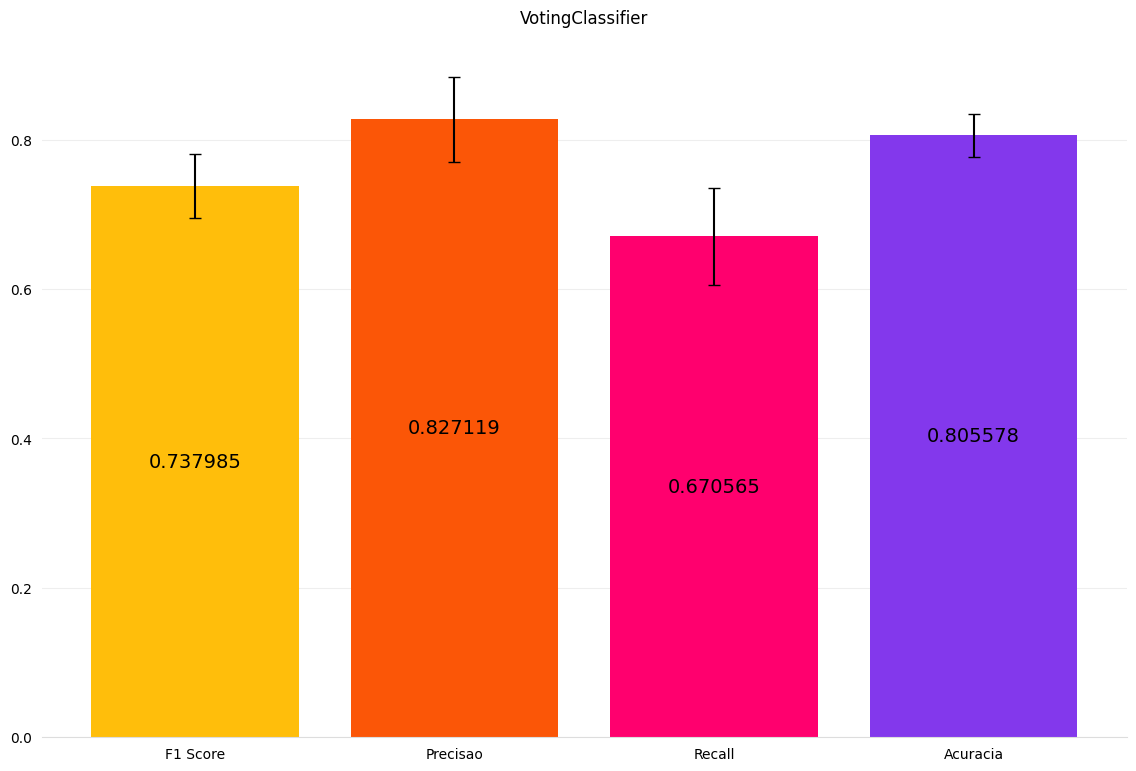

In [98]:
fig, ax = plt.subplots(figsize=(14, 9))

for (score_name, score, std) in [
    ('F1 Score', ensemble_mean_f1_score, ensemble_std_f1_score),
    ('Precisao', ensemble_mean_precision_score, ensemble_std_precision_score),
    ('Recall', ensemble_mean_recall_score, ensemble_std_recall_score), 
    ('Acuracia',ensemble_mean_accuracy_score, ensemble_std_accuracy_score)
]: 
    ensemble_bar = ax.bar(
        score_name, score, yerr=std, capsize=4,
    )
    ax.bar_label(ensemble_bar, label_type='center', fontsize=14)

ax.set_title('VotingClassifier', pad=15)

ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
ax.set_axisbelow(True)
ax.tick_params(bottom=False, left=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')


plt.show()

In [58]:
ensemble_mean_accuracy_score

np.float64(0.8055777555777557)

# Redução de dimensionalidade
Executando o algoritmo *RandomForestClassifier* com todas as características do *dataset* para ter uma base de comparação

### Relieff

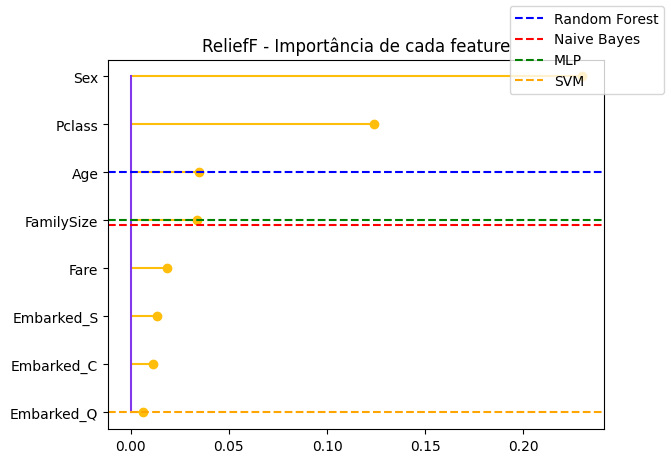

In [179]:
# Computando a importância sem realizar a seleção em sí
# https://epistasislab.github.io/scikit-rebate/using/
relieff_fs = ReliefF()
relieff_fs.fit(X_train.values, y_train.values);

# Sorting
relieff_importance = (
    (X_train.columns[i], relieff_fs.feature_importances_[i]) for i in range(len(X_train.columns))
)
relieff_importance = sorted(relieff_importance, key=lambda x: x[1])
feat, importance = zip(*relieff_importance)

# Plotting
fig, ax = plt.subplots()
ax.stem(feat, importance, orientation='horizontal')
ax.axhline(
    y=(len(feat) - rf_relieff_grid_search_clf.best_params_['relieff__n_features_to_select']), 
    color='blue',
    linestyle='--',
    label='Random Forest'
)
ax.axhline(
    y=3.90, 
    color='red', 
    linestyle='--', 
    label='Naive Bayes'
)
ax.axhline(
    y=(len(feat) - mlp_relieff_grid_search_clf.best_params_['relieff__n_features_to_select']), 
    color='green',
    linestyle='--',
    label='MLP'
)
ax.axhline(
    y=(len(feat) - svm_relieff_grid_search_clf.best_params_['relieff__n_features_to_select']), 
    color='orange',
    linestyle='--',
    label='SVM'
)
ax.set_title('ReliefF - Importância de cada feature')
fig.legend()
plt.show()

### Sequential feature selector (backwards)

In [ ]:
clf = GaussianNB()
sfs = feature_selection.SequentialFeatureSelector(clf, direction='backward')
skf = StratifiedKFold(n_splits=10)

# sfs_grid_search = model_selection.GridSearchCV(estimator=sfs, param_grid={'n_features_to_select': range(1, 10)}, cv=skf, scoring='accuracy')
# sfs_grid_search.fit(X_train, y_train)

sfs.fit(X_train.values, y_train.values)
sfs_X_train = sfs.transform(X_train)
sfs_X_test = sfs.transform(X_test)

clf.fit(sfs_X_train, y_train)
sfs_y_pred = clf.predict(sfs_X_test)

sfs_f1_score = cross_val_score(clf, sfs_X_train, y_train, cv=K_FOLD, scoring='f1_weighted')
sfs_precision_score = cross_val_score(clf, sfs_X_train, y_train, cv=K_FOLD, scoring='precision')
sfs_recall_score = cross_val_score(clf, sfs_X_train, y_train, cv=K_FOLD, scoring='recall')
sfs_accuracy_score = cross_val_score(clf, sfs_X_train, y_train, cv=K_FOLD, scoring='accuracy')

# clf = GridSearchCV(pca_gnb, parameters)
# clf.fit(df_pca, y_train)

results_df.at['sfs', 'f1_mean'] = np.mean(sfs_f1_score)
results_df.at['sfs', 'f1_std'] = np.std(scores)

results_df.at['sfs', 'precision_mean'] = np.mean(sfs_precision_score)
results_df.at['sfs', 'precision_std'] = np.std(sfs_precision_score)

results_df.at['sfs', 'recall_mean'] = np.mean(sfs_recall_score)
results_df.at['sfs', 'recall_std'] = np.std(sfs_recall_score)

results_df.at['sfs', 'accuracy_mean'] = np.mean(sfs_accuracy_score)
results_df.at['sfs', 'accuracy_std'] = np.std(sfs_accuracy_score)

In [ ]:
selected_features = [
    feature for feature,
    selected in zip(X_train.columns.values, sfs.get_support())
    if selected is np.True_
]

In [ ]:
clf = RandomForestClassifier()
sfs_scores = []
clf_processing_time = []
# Testing the accuracy each feature
for i in range(1, 10):
    start = time.time() 
    sfs = SFS(clf,
          k_features=i, # number of features to select
          forward=True,
          floating=False,
          scoring='accuracy',
          cv=0)
    new_x = sfs.fit_transform(X_train, y_train)    
    sfs_scores.append(np.mean(cross_val_score(clf, new_x, y_train.values, scoring='accuracy', cv=100)))
    end = time.time()
    clf_processing_time.append(end - start)

In [ ]:
fig, ax = plt.subplots()
ax.plot(list(range(1, 10)), clf_processing_time)
ax.set_ylabel('Tempo para a execução do modelo de classificação')
ax.set_xlabel('Quantidade de características')
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot(list(range(1, 10)), sfs_scores, label='SFS')
ax.plot(list(range(1, 10)), scores, label='ReliefF')
ax.set_ylabel('Média da pontuação de validação cruzada')
ax.set_xlabel('Quantidade de características')
ax.legend()
ax.set_title('Comparação dos algoritmos de seleção')
plt.show()

In [ ]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

### PCA

In [ ]:
pca = PCA()
X_pca = pca.fit_transform(X_train)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(6,4))
plt.plot(range(1, len(explained_variance)+1), explained_variance.cumsum(), marker='o')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [ ]:
# Apply PCA for 4 components
pca = PCA(n_components=4)
principal_components = pca.fit_transform(X_train)  # df should be your original DataFrame
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4'])
principal_components_test = pca.fit_transform(X_test)  # df should be your original DataFrame
df_pca_test = pd.DataFrame(data=principal_components_test, columns=['PC1', 'PC2', 'PC3', 'PC4'])

# Combine the original DataFrame with the new principal components
df_combined = pd.concat([X_train, df_pca], axis=1)

# Calculate the correlation between the original variables and the principal components
correlation_matrix = pd.DataFrame(index=X_train.columns, columns=df_pca.columns)

for col in X_train.columns:
    for pc in df_pca.columns:
        correlation_matrix.loc[col, pc] = df_combined[col].corr(df_combined[pc])

# Display the correlation matrix
correlation_matrix

In [ ]:
pca_gnb = GaussianNB()
pca_f1_score = cross_val_score(pca_gnb, df_pca, y_train, cv=K_FOLD, scoring='f1_weighted')
pca_precision_score = cross_val_score(pca_gnb, df_pca, y_train, cv=K_FOLD, scoring='precision')
pca_recall_score = cross_val_score(pca_gnb, df_pca, y_train, cv=K_FOLD, scoring='recall')
pca_accuracy_score = cross_val_score(pca_gnb, df_pca, y_train, cv=K_FOLD, scoring='accuracy')

# clf = GridSearchCV(pca_gnb, parameters)
# clf.fit(df_pca, y_train)

results_df.at['pca', 'f1_mean'] = np.mean(pca_f1_score)
results_df.at['pca', 'f1_std'] = np.std(scores)

results_df.at['pca', 'precision_mean'] = np.mean(pca_precision_score)
results_df.at['pca', 'precision_std'] = np.std(pca_precision_score)

results_df.at['pca', 'recall_mean'] = np.mean(pca_recall_score)
results_df.at['pca', 'recall_std'] = np.std(pca_recall_score)

results_df.at['pca', 'accuracy_mean'] = np.mean(pca_accuracy_score)
results_df.at['pca', 'accuracy_std'] = np.std(pca_accuracy_score)

# pca_gnb_y_pred = y_pred = gnb.fit(df_pca, y_train).predict(df_pca_test)

# Resutados

## Matriz de confusão

In [ ]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(20,6))

all_feat_conf_matrix = metrics.confusion_matrix(y_test, all_feat_y_pred)
all_disp = metrics.ConfusionMatrixDisplay(all_feat_conf_matrix)
all_disp.plot(cmap=plt.cm.Blues, ax=ax0)
ax0.set_title('Todas as features')

relieff_conf_matrix = metrics.confusion_matrix(y_test, relieff_y_pred)
relieff_disp = metrics.ConfusionMatrixDisplay(relieff_conf_matrix)
relieff_disp.plot(cmap=plt.cm.Blues, ax=ax1)
ax1.set_title('Relieff')

pca_conf_matrix = metrics.confusion_matrix(y_test, pca_gnb_y_pred)
pca_disp = metrics.ConfusionMatrixDisplay(pca_conf_matrix)
pca_disp.plot(cmap=plt.cm.Blues, ax=ax2)
ax2.set_title('PCA')

sfs_conf_matrix = metrics.confusion_matrix(y_test, sfs_y_pred)
sfs_disp = metrics.ConfusionMatrixDisplay(sfs_conf_matrix)
sfs_disp.plot(cmap=plt.cm.Blues, ax=ax3)
ax3.set_title('SFS')

plt.show()

## F1 Score

In [ ]:
sns.set_palette(["#FFBE0B", "#FB5607", "#FF006E", "#8338EC"])

In [ ]:
labels = results_df.f1_mean.keys()
x = np.arange(len(labels))
bar_width = .2
fig, ax = plt.subplots(figsize=(14, 7))

naive_bayes_bar = ax.bar(
    x,
    results_df.f1_mean,
    yerr=results_df.f1_std,
    capsize=4,
    label='Naive Bayes',
    width=bar_width
)

rand_forest_bar = ax.bar(
    x + bar_width,
    rf_results_df.f1_mean,
    yerr=rf_results_df.f1_std,
    capsize=4,
    label='Random Forest',
    width=bar_width
)

svm_bar = ax.bar(
    x + bar_width * 2,
    svm_results_df.f1_mean,
    yerr=svm_results_df.f1_std,
    capsize=4,
    label='SVM',
    width=bar_width
)

mlp_bar = ax.bar(
    x + bar_width * 3,
    mlp_results_df.f1_mean,
    yerr=mlp_results_df.f1_std,
    capsize=4,
    label='MLP',
    width=bar_width
)

# Adicionando os números no topo das barras
def add_bar_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # Centraliza o texto na barra
            height/3,  # Altura do texto
            f'{height:.2f}',  # Formata o texto
            ha='center', va='bottom', fontsize=10  # Alinhamento e tamanho da fonte
        )

add_bar_labels(naive_bayes_bar)
add_bar_labels(rand_forest_bar)
add_bar_labels(svm_bar)
add_bar_labels(mlp_bar)

ax.legend()

ax.set_xticks(x + bar_width)
ax.set_xticklabels(labels)
ax.set_title('F1 score', pad=15)

ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
ax.set_axisbelow(True)
ax.tick_params(bottom=False, left=False)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

plt.show()

## Precisão

In [ ]:
labels = results_df.precision_mean.keys()
x = np.arange(len(labels))
bar_width = .2
fig, ax = plt.subplots(figsize=(14, 7))

naive_bayes_bar = ax.bar(
    x,
    results_df.precision_mean,
    yerr=results_df.precision_std,
    capsize=4,
    label='Naive Bayes',
    width=bar_width,
)

rand_forest_bar = ax.bar(
    x + bar_width,
    rf_results_df.precision_mean,
    yerr=rf_results_df.precision_std,
    capsize=4,
    label='Random Forest',
    width=bar_width
)

svm_bar = ax.bar(
    x + bar_width * 2,
    svm_results_df.precision_mean,
    yerr=svm_results_df.precision_std,
    capsize=4,
    label='SVM',
    width=bar_width
)

mlp_bar = ax.bar(
    x + bar_width * 3,
    mlp_results_df.precision_mean,
    yerr=mlp_results_df.precision_std,
    capsize=4,
    label='MPL',
    width=bar_width
)

# Adicionando os números no topo das barras
def add_bar_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # Centraliza o texto na barra
            height/3,  # Altura do texto
            f'{height:.2f}',  # Formata o texto
            ha='center', va='bottom', fontsize=10  # Alinhamento e tamanho da fonte
        )

add_bar_labels(naive_bayes_bar)
add_bar_labels(rand_forest_bar)
add_bar_labels(svm_bar)
add_bar_labels(mlp_bar)

ax.legend()

ax.set_xticks(x + bar_width)
ax.set_xticklabels(labels)
ax.set_title('Precisão com desvio padrão', pad=15)

ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
ax.set_axisbelow(True)
ax.tick_params(bottom=False, left=False)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

plt.show()

## Revocação

In [ ]:
labels = results_df.precision_mean.keys()
x = np.arange(len(labels))
bar_width = .2
fig, ax = plt.subplots(figsize=(14, 7))

naive_bayes_bar = ax.bar(
    x,
    results_df.recall_mean,
    yerr=results_df.recall_std,
    capsize=4,
    label='Naive Bayes',
    width=bar_width
)

rand_forest_bar = ax.bar(
    x + bar_width,
    rf_results_df.recall_mean,
    yerr=rf_results_df.recall_std,
    capsize=4,
    label='Random Forest',
    width=bar_width
)

svm_bar = ax.bar(
    x + bar_width * 2,
    svm_results_df.recall_mean,
    yerr=svm_results_df.recall_std,
    capsize=4,
    label='SVM',
    width=bar_width
)

mlp_bar = ax.bar(
    x + bar_width * 3,
    mlp_results_df.recall_mean,
    yerr=mlp_results_df.recall_std,
    capsize=4,
    label='MLP',
    width=bar_width
)

# Adicionando os números no topo das barras
def add_bar_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # Centraliza o texto na barra
            height/3,  # Altura do texto
            f'{height:.2f}',  # Formata o texto
            ha='center', va='bottom', fontsize=10  # Alinhamento e tamanho da fonte
        )

add_bar_labels(naive_bayes_bar)
add_bar_labels(rand_forest_bar)
add_bar_labels(svm_bar)
add_bar_labels(mlp_bar)

ax.legend()

ax.set_xticks(x + bar_width)
ax.set_xticklabels(labels)
ax.set_title('Revocação com desvio padrão', pad=15)

ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
ax.set_axisbelow(True)
ax.tick_params(bottom=False, left=False)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

plt.show()

## Acurácia

In [ ]:
labels = results_df.precision_mean.keys()
x = np.arange(len(labels))
bar_width = .2
fig, ax = plt.subplots(figsize=(14, 7))

naive_bayes_bar = ax.bar(
    x,
    results_df.accuracy_mean,
    yerr=results_df.accuracy_std,
    capsize=4,
    label='Naive Bayes',
    width=bar_width
)

rand_forest_bar = ax.bar(
    x + bar_width,
    rf_results_df.accuracy_mean,
    yerr=rf_results_df.accuracy_std,
    capsize=4,
    label='Random Forest',
    width=bar_width
)

svm_bar = ax.bar(
    x + bar_width * 2,
    svm_results_df.accuracy_mean,
    yerr=svm_results_df.accuracy_std,
    capsize=4,
    label='SVM',
    width=bar_width
)

mlp_bar = ax.bar(
    x + bar_width * 3,
    mlp_results_df.accuracy_mean,
    yerr=mlp_results_df.accuracy_std,
    capsize=4,
    label='MLP',
    width=bar_width
)
# Adicionando os números no topo das barras
def add_bar_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # Centraliza o texto na barra
            height/3,  # Altura do texto
            f'{height:.2f}',  # Formata o texto
            ha='center', va='bottom', fontsize=10  # Alinhamento e tamanho da fonte
        )

add_bar_labels(naive_bayes_bar)
add_bar_labels(rand_forest_bar)
add_bar_labels(svm_bar)
add_bar_labels(mlp_bar)

ax.legend()

ax.set_xticks(x + bar_width)
ax.set_xticklabels(labels)
ax.set_title('Acurácia com desvio padrão', pad=15)

ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
ax.set_axisbelow(True)
ax.tick_params(bottom=False, left=False)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

plt.show()

## Tempo de execução

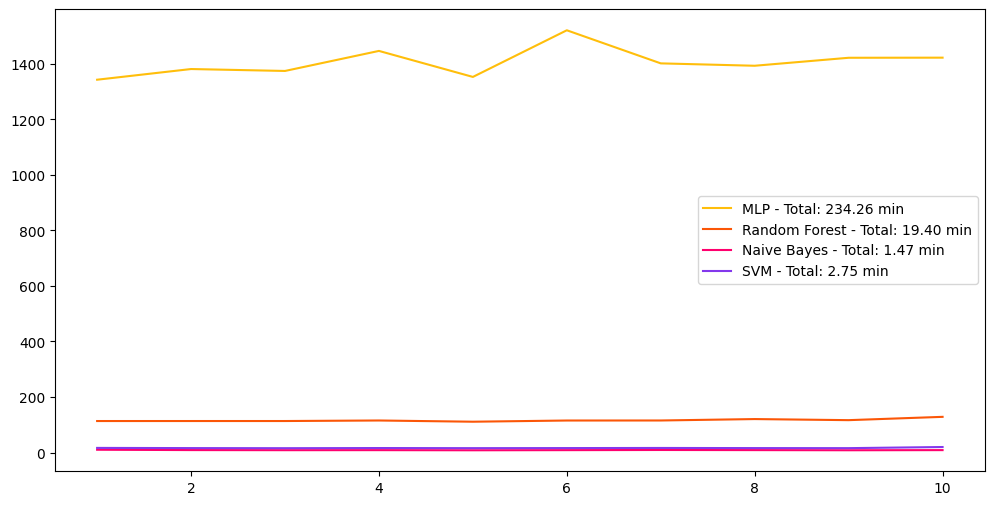

In [166]:
fig, ax = plt.subplots(figsize=(12, 6))

total_mlp = f'{np.sum(mlp_execution_time)/60:.2f}'
total_nb = f'{np.sum(nb_execution_time)/60:.2f}'
total_svm = f'{np.sum(svc_execution_time)/60:.2f}'
total_rf = f'{np.sum(rf_execution_time)/60:.2f}'

ax.plot(list(range(1, 11)), mlp_execution_time, label=f'MLP - Total: {total_mlp} min')
ax.plot(list(range(1, 11)), rf_execution_time, label=f'Random Forest - Total: {total_rf} min')
ax.plot(list(range(1, 11)), nb_execution_time, label=f'Naive Bayes - Total: {total_nb} min')
ax.plot(list(range(1, 11)), svc_execution_time, label=f'SVM - Total: {total_svm} min')

ax.legend()
plt.show()